In [1]:
#!/usr/bin/python
import os
import sys
import time
import numpy as np
import copy
import scipy
import pickle
import builtins
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn.functional as F
from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import StepLR, MultiStepLR

from config_weight_analysis import configurations
from backbone import *
from head import *
from loss.loss import *
from dataset import *
from util.utils import *
from util.flops_counter import *
from optimizer.lr_scheduler import *
from optimizer.optimizer import *

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    

cfg = configurations[1]


# VAL_DATA_ROOT = cfg['VAL_DATA_ROOT']
# VAL_SET = cfg['VAL_SET']
VAL_IN_LOWRES = cfg['VAL_IN_LOWRES']
INPUT_SIZE = [32, 32] if VAL_IN_LOWRES else [144, 144]

BACKBONE_RESUME_ROOT = cfg['BACKBONE_RESUME_ROOT'] # the root to resume training from a saved checkpoint, # highlow
BACKBONE2_RESUME_ROOT = "/Volumes/LaCie/HD-Faces-main_logs/model/debug_lowres_144/model/Backbone_IR_SE_18_Epoch_11_Time_2021-01-29-14-12_checkpoint.pth"
        
IS_RESUME = cfg['IS_RESUME']
BACKBONE_NAME = cfg['BACKBONE_NAME'] #ARCHITECTURE

#workers = int((cfg['NUM_WORKERS'] + ngpus_per_node - 1) / ngpus_per_node) # dataload threads
workers = int(cfg['NUM_WORKERS'])
DATA_ROOT = cfg['DATA_ROOT'] # the parent root where your train/val/test data are stored
#RECORD_DIR = cfg['DATA_RECORD']
EMBEDDING_SIZE = cfg['EMBEDDING_SIZE'] # feature dimension

# name to csv of features
eval_name = cfg['CSV_NAME']
    
GPU_AVAILABLE = torch.cuda.is_available()
# GPU_AVAILABLE = False
            
if GPU_AVAILABLE:
    device = torch.device('cuda:0')
    ngpus_per_node = len(cfg['GPU'])
    cfg['GPU'] = cfg['GPU'][0]
    world_size = cfg['WORLD_SIZE']
    cfg['WORLD_SIZE'] = ngpus_per_node * world_size
    cfg['GPU'] = 'cuda'

else:
    ngpus_per_node = 1
    device = torch.device('cpu')
    cfg['GPU'] = 'cpu'

batch_size = int(cfg['BATCH_SIZE'])
per_batch_size = int(batch_size / ngpus_per_node)

   
############################################################################
# Resume backbone from a checkpoint
# INPUT_SIZE = cfg['INPUT_SIZE']

BACKBONE_DICT = {'MobileFaceNet': MobileFaceNet,
                     'ResNet_50': ResNet_50, 'ResNet_101': ResNet_101, 'ResNet_152': ResNet_152, 'IR_SE_18': IR_SE_18,
                     'IR_50': IR_50, 'IR_100': IR_100, 'IR_101': IR_101, 'IR_152': IR_152, 'IR_185': IR_185, 'IR_200': IR_200,
                     'IR_SE_50': IR_SE_50, 'IR_SE_100': IR_SE_100, 'IR_SE_101': IR_SE_101, 'IR_SE_152': IR_SE_152, 'IR_SE_185': IR_SE_185, 'IR_SE_200': IR_SE_200,
                     'AttentionNet_IR_56': AttentionNet_IR_56,'AttentionNet_IRSE_56': AttentionNet_IRSE_56,'AttentionNet_IR_92': AttentionNet_IR_92,'AttentionNet_IRSE_92': AttentionNet_IRSE_92,
                     'ResNeSt_50': resnest50, 'ResNeSt_101': resnest101, 'ResNeSt_100': resnest100,
                     'GhostNet': GhostNet, 'MobileNetV3': MobileNetV3, 'ProxylessNAS': proxylessnas, 'EfficientNet': efficientnet,
                     'DenseNet': densenet, 'ReXNetV1': ReXNetV1, 'MobileNeXt': MobileNeXt, 'MobileNetV2': MobileNetV2
                    } #'HRNet_W30': HRNet_W30, 'HRNet_W32': HRNet_W32, 'HRNet_W40': HRNet_W40, 'HRNet_W44': HRNet_W44, 'HRNet_W48': HRNet_W48, 'HRNet_W64': HRNet_W64


backbone = BACKBONE_DICT[BACKBONE_NAME](INPUT_SIZE)
backbone2 = BACKBONE_DICT[BACKBONE_NAME](INPUT_SIZE)

if IS_RESUME:
    print("=" * 60)
    if os.path.isfile(BACKBONE_RESUME_ROOT):
        print("Loading Backbone Checkpoint '{}'".format(BACKBONE_RESUME_ROOT))
        #loc = '{}:0'.format(cfg['GPU'])
        loc = 'cpu'
        backbone.load_state_dict(torch.load(BACKBONE_RESUME_ROOT, map_location=loc))
    else:
        print("No Checkpoint Found at '{}'. Please Have a Check or Continue to Train from Scratch".format(BACKBONE_RESUME_ROOT))
    print("=" * 60)
        
    print("=" * 60)
    if os.path.isfile(BACKBONE2_RESUME_ROOT):
        print("Loading Backbone Checkpoint '{}'".format(BACKBONE2_RESUME_ROOT))
        #loc = '{}:0'.format(cfg['GPU'])
        loc = 'cpu'
        backbone2.load_state_dict(torch.load(BACKBONE2_RESUME_ROOT, map_location=loc))
    else:
        print("No Checkpoint Found at '{}'. Please Have a Check or Continue to Train from Scratch".format(BACKBONE2_RESUME_ROOT))
    print("=" * 60)
        
        
    
#backbone = torch.nn.DataParallel(backbone, device_ids=[cfg['GPU']] if GPU_AVAILABLE else None)
# print backbone 
    
print("Params: ", count_model_params(backbone))
print("Flops:", count_model_flops(backbone, input_res=INPUT_SIZE, device=device))
    
print("Params: ", count_model_params(backbone2))
print("Flops:", count_model_flops(backbone2, input_res=INPUT_SIZE, device=device))

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True


Loading Backbone Checkpoint '/Volumes/LaCie/HD-Faces-main_logs/debug_highlow_144/model/Backbone_IR_SE_18_Epoch_12_Time_2021-02-01-02-46_checkpoint.pth'
No Checkpoint Found at '/Volumes/LaCie/HD-Faces-main_logs/model/debug_lowres_144/model/Backbone_IR_SE_18_Epoch_11_Time_2021-01-29-14-12_checkpoint.pth'. Please Have a Check or Continue to Train from Scratch
Params:  16.57 M
Flops: 8.57 GFLOPS
Params:  16.57 M
Flops: 8.57 GFLOPS


In [22]:
import seaborn as sns

def plot_kernels(tensor, num_cols=6):
    
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()

    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    

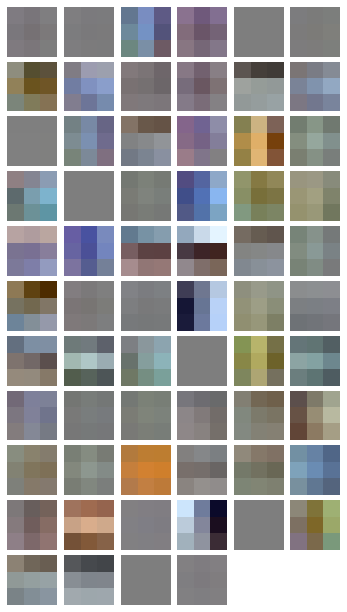

In [23]:
# INPUT
tensor = backbone.input_layer[0].weight.data.numpy()
plot_kernels(tensor, num_cols=6)


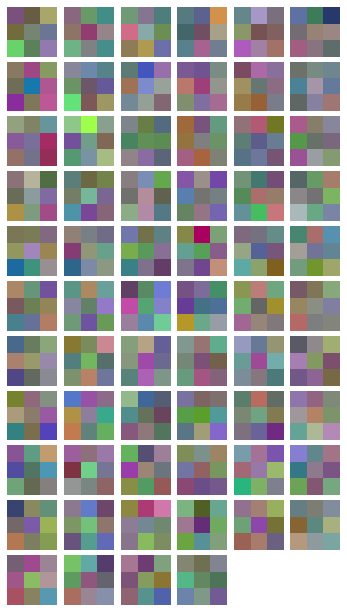

In [24]:
tensor2 = backbone2.input_layer[0].weight.data.numpy()
plot_kernels(tensor2, num_cols=6)

In [14]:
number_modules = len(backbone.body)
print("Number modules:", number_modules)
print("Example module:")
backbone.body[0]

Number modules: 8
Example module:


bottleneck_IR_SE(
  (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  (res_layer): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): PReLU(num_parameters=64)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SEModule(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (sigmoid): Sigmoid()
    )
  )
)

In [20]:
def normalize_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

for mod in range(number_modules):
    
    conv1_tensor = normalize_tensor(backbone.body[mod].res_layer[1].weight.data)
    print(conv1_tensor.shape)
    sums_kernel1 = [conv1_tensor[i].sum() for i in range(conv1_tensor.shape[0])]
    conv2_tensor = normalize_tensor(backbone.body[mod].res_layer[3].weight.data)
    sums_kernel2 = [conv2_tensor[i].sum() for i in range(conv2_tensor.shape[0])]
    
    total_sum_kernel1 = sum(sums_kernel1)
    total_sum_kernel2 = sum(sums_kernel2)

    print("Backbone body module",mod,": Conv1 kernel sum", total_sum_kernel1, ", Conv3 kernel Sum:", total_sum_kernel2)

    conv1_tensor_2 = normalize_tensor(backbone2.body[mod].res_layer[1].weight.data)
    sums_kernel1_2 = [conv1_tensor_2[i].sum() for i in range(conv1_tensor_2.shape[0])]
    conv2_tensor_2 = normalize_tensor(backbone2.body[mod].res_layer[3].weight.data)
    sums_kernel2_2 = [conv2_tensor_2[i].sum() for i in range(conv2_tensor_2.shape[0])]
    
    total_sum_kernel1_2 = sum(sums_kernel1_2)
    total_sum_kernel2_2 = sum(sums_kernel2_2)
    
    print("Backbone2 body module",mod,": Conv2 kernel sum",total_sum_kernel1_2, ", Conv3 kernel Sum:", total_sum_kernel2_2)
    
    print("Difference backbone - backbone2: Conv1:", total_sum_kernel1 - total_sum_kernel1_2, ", Conv3:", total_sum_kernel2 - total_sum_kernel2_2) 
    

    print()
    
    

torch.Size([64, 64, 3, 3])
Backbone body module 0 : Conv1 kernel sum tensor(17818.4453) , Conv3 kernel Sum: tensor(18546.9941)
Backbone2 body module 0 : Conv2 kernel sum tensor(18142.9219) , Conv3 kernel Sum: tensor(17307.6816)
Difference backbone - backbone2: Conv1: tensor(-324.4766) , Conv2: tensor(1239.3125)

torch.Size([64, 64, 3, 3])
Backbone body module 1 : Conv1 kernel sum tensor(16618.2070) , Conv3 kernel Sum: tensor(15239.2314)
Backbone2 body module 1 : Conv2 kernel sum tensor(17781.2520) , Conv3 kernel Sum: tensor(17562.0957)
Difference backbone - backbone2: Conv1: tensor(-1163.0449) , Conv2: tensor(-2322.8643)

torch.Size([128, 64, 3, 3])
Backbone body module 2 : Conv1 kernel sum tensor(39175.8555) , Conv3 kernel Sum: tensor(73798.7812)
Backbone2 body module 2 : Conv2 kernel sum tensor(32620.6270) , Conv3 kernel Sum: tensor(67090.5703)
Difference backbone - backbone2: Conv1: tensor(6555.2285) , Conv2: tensor(6708.2109)

torch.Size([128, 128, 3, 3])
Backbone body module 3 : C

In [19]:
# BODY [0]
conv1_tensor = backbone.body[0].res_layer[1].weight.data
sums_kernel1 = [conv1_tensor[i].sum() for i in range(conv1_tensor.shape[0])]
conv2_tensor = backbone.body[0].res_layer[3].weight.data
sums_kernel2 = [conv2_tensor[i].sum() for i in range(conv2_tensor.shape[0])]

print("Backbone body0: Conv1 kernel sum",sum(sums_kernel1), ", Conv3 kernel Sum:", sum(sums_kernel2))

conv1_tensor = backbone2.body[0].res_layer[1].weight.data
sums_kernel1 = [conv1_tensor[i].sum() for i in range(conv1_tensor.shape[0])]
conv2_tensor = backbone2.body[0].res_layer[3].weight.data
sums_kernel2 = [conv2_tensor[i].sum() for i in range(conv2_tensor.shape[0])]
print("Backbone2 body0: Conv1 kernel sum",sum(sums_kernel1), ", Conv3 kernel Sum:", sum(sums_kernel2))

torch.Size([64, 64, 3, 3])
Backbone body0: Conv1 kernel sum tensor(-9.2009) , Conv3 kernel Sum: tensor(-0.6792)
Backbone2 body0: Conv1 kernel sum tensor(-8.0925) , Conv3 kernel Sum: tensor(-11.3107)


In [169]:
conv1_tensor = backbone2.body[0].res_layer[1].weight.data
sums_kernel1 = [conv1_tensor[i].sum() for i in range(conv1_tensor.shape[0])]
conv2_tensor = backbone2.body[0].res_layer[3].weight.data
sums_kernel2 = [conv2_tensor[i].sum() for i in range(conv2_tensor.shape[0])]
print("Backbone2 body0: Conv1 kernel sum",sum(sums_kernel1), ", Conv3 kernel Sum:", sum(sums_kernel2))

Backbone2 body0: Conv1 kernel sum tensor(-10.8326) , Conv3 kernel Sum: tensor(-15.9781)


In [ ]:
# BODY [1]
conv1_tensor = backbone.body[0].res_layer[1].weight.data
sums_kernel1 = [conv1_tensor[i].sum() for i in range(conv1_tensor.shape[0])]
conv2_tensor = backbone.body[0].res_layer[3].weight.data
sums_kernel2 = [conv2_tensor[i].sum() for i in range(conv2_tensor.shape[0])]
print(sum(sums_kernel1), sum(sums_kernel2))